# Apply CellCap to human monocytes data

This tutorial shows how to setup CellCap for dissecting perturbation programs in simulation data. The simulation data has a simple setup, with two perturbation conditions and one control group. The control group covers two cell states, and two perturbations would induce two distinct programs in a cell state A, while sharing one program in the other cell state B. The goal here is to identify these two programs are specific to these two perturbations and cell state A. At the same time, CellCap should reveal the the shared program is specific to cell state B.

Through this tutorial, we will primarily show hyperparameter setup is critical for CellCap to model the correspondece between cellular identity and perturbation response. A few examples below will show that CellCap reaches to different conclusions due to different hyperparameter setups.

* [Load packages](#Load-packages)
* [Load a trained CellCap model](#load-model)
* [Visualize relationship of perturbations](#visual-pert)
* [Identify perturbation program of interest](#program-of-interest)
* [Uncover the corresponded basal state](#basal-state)

## Load packages <a class="anchor" id="Load-packages"></a>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import scvi
from cellcap.scvi_module import CellCap
from cellcap.utils import cosine_distance, identify_top_perturbed_genes

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
from scipy.ndimage import gaussian_filter1d

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [5]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100,vector_friendly=True)

In [6]:
%%html
<style>
table {float:left}
</style>

## Load a trained CellCap model <a class="anchor" id="Load-model"></a>
We previously trained CellCap on this human monocytes data. Here, we will just load this trained model for downstream analyses. To reproduce this training outcome, we have hyperparameter setup as below:

|Hyperparameter name|Value|
|:-----------------:|:---:|
|`rec_weight`       |2.0  | 
|`kl_weight`        |1.0  | 
|`lamda`            |1.0  | 
|`ard_kl_weight`    |0.2  | 
|`n_head`           |2    | 
|`n_prog`           |10   |

In [7]:
#load anndata
adata = sc.read_h5ad("../data/model/CellCap_1MPBMC_Mono.h5ad")

_, drug_names = pd.factorize(adata.obs['timepoint'])
drug_names = list(drug_names)
drug_names.remove('UT')

In [8]:
#load trained CellCap model
CellCap.setup_anndata(adata,layer="counts",covar_key='X_batch',target_key='X_target')

cellcap = CellCap(adata, n_drug=6,n_covar=1,n_prog=10,n_head=2)

cellcap = cellcap.load('../data/model/CellCap_1MPBMC_Mono/', adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     File ../data/model/CellCap_1MPBMC_Mono/model.pt already downloaded                                        


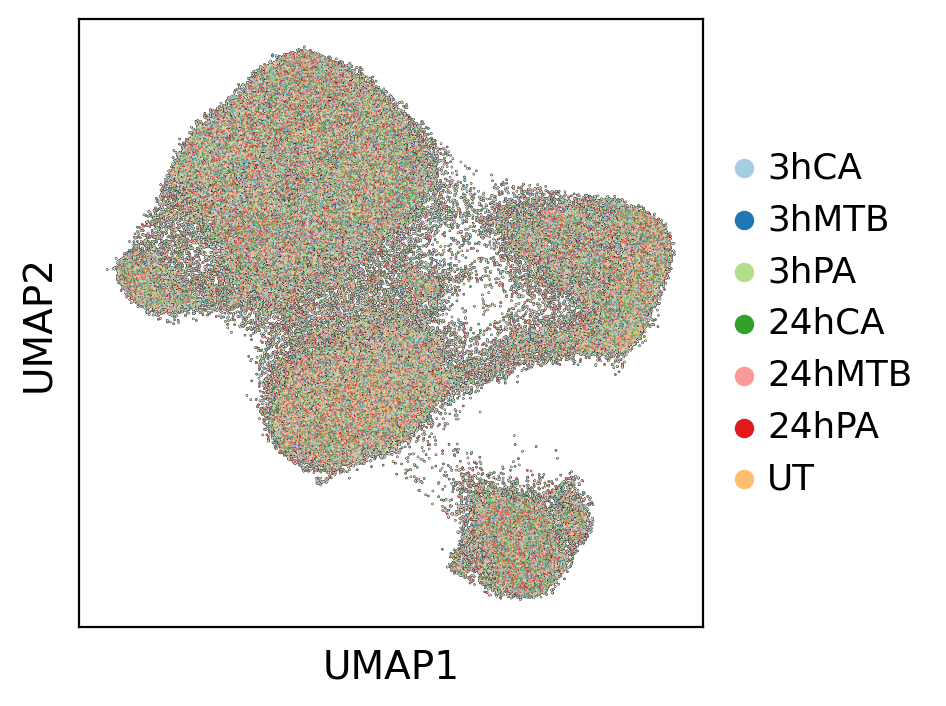

In [9]:
#Visualization of basal state
sc.pl.umap(adata, color='timepoint', title='', add_outline=True, palette=sns.color_palette("Paired"))

## Visualize relationship of perturbations <a class="anchor" id="visual-pert"></a>
We then use learned `H` to understand the general relationships of different perturbations. `H` is a `6 X 10` table in this case, and we can use PCA to visualize perturbation relationship in a lower dimension.

In [10]:
#get H
n_prog = cellcap.module.n_prog
h = cellcap.get_h()
h = pd.DataFrame(h)
h.index = drug_names
h.columns = ['Q'+str(i) for i in range(1,(n_prog+1))]
h = h.loc[['3hCA','3hMTB','3hPA','24hCA','24hMTB','24hPA'],:]

In [11]:
#PCA
pca = PCA(n_components=2)
h_pc = h.values
h_pc = pca.fit_transform(h_pc)

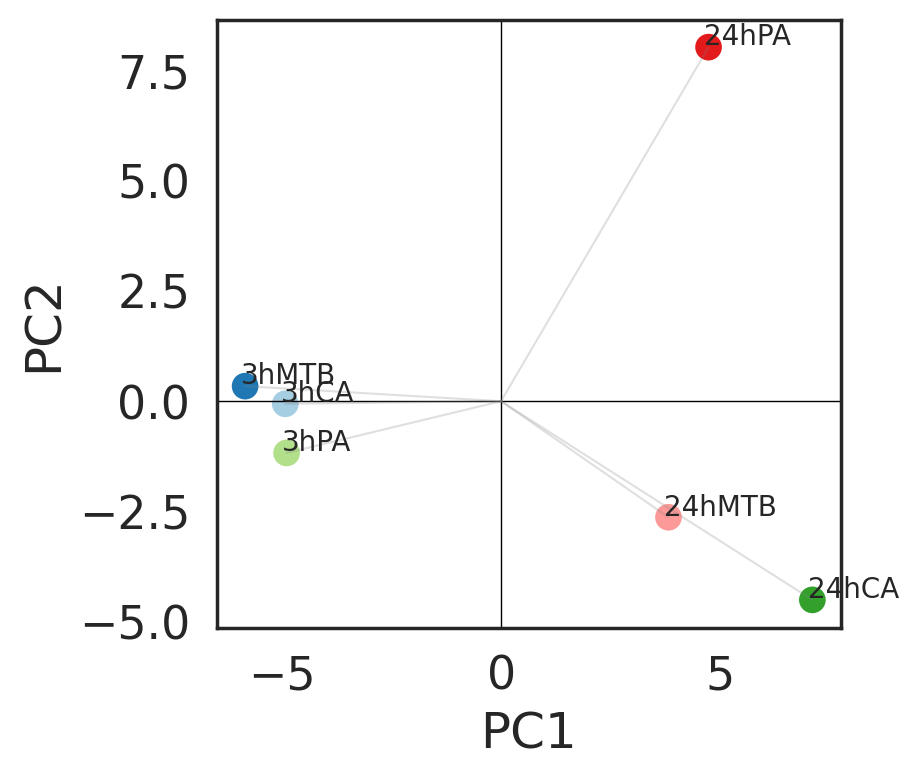

In [12]:
sns.set_theme(style='white', font_scale=1.5)
distances = np.sqrt(h_pc[:,0]**2 + h_pc[:,1]**2)
plt.scatter(h_pc[:,0], h_pc[:,1], c=list(sns.color_palette("Paired"))[:6], 
            marker='.', s=450, edgecolor='white')
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line through the origin
plt.axvline(0, color='black', linewidth=0.5)  # Vertical line through the origin

# Connect points to the origin
num_points = h_pc.shape[0]
for i in range(num_points):
    plt.plot([0, h_pc[:,0][i]], [0, h_pc[:,1][i]], 'grey', linewidth=0.75,alpha=0.25)
    
label_offset = 0.05  # Offset for label position
for i in range(num_points):
    plt.text(h_pc[:,0][i]- label_offset*2, h_pc[:,1][i]+ label_offset, h.index[i], fontsize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The first two principal components indicated that time points are major variation across conditions. Three pathogens have similar behavior in human monocytes at 3h time point. PA after 24 hours exposure stands out from the other two pathogens, suggensting existence of specific perturbation program.

Next, we combine `A` and `H` to reveal perturbation relationship under the context of human monocytes.

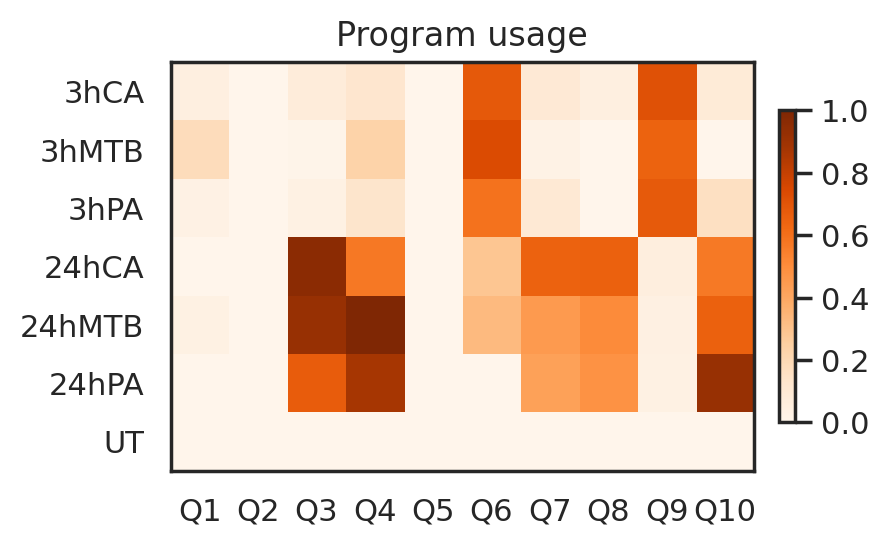

In [13]:
h_attn = cellcap.get_h_attn()
df = pd.DataFrame(h_attn, index=adata.obs_names)
df["condition"] = adata.obs['timepoint'].copy()
h_attn_per_perturbation = df.groupby("condition").quantile(.90)
    
max_h = np.max(h_attn_per_perturbation.values)
h_attn_per_perturbation = h_attn_per_perturbation/max_h
    
sns.set_theme(style='white', font_scale=1)
im = plt.imshow(h_attn_per_perturbation.to_numpy(), cmap="Oranges", 
                vmin=0, vmax=1)
plt.grid(False)
plt.xticks(
    ticks=range(h_attn.shape[1]),
    labels=["Q"+ str(i+1) for i in range(h_attn.shape[1])],
    #rotation=45
)
plt.yticks(
    ticks=range(len(h_attn_per_perturbation)),
    labels=h_attn_per_perturbation.index,
)
plt.title("Program usage")
plt.colorbar(im, fraction=0.025, pad=0.04)

## Identify perturbation program of interest <a class="anchor" id="program-of-interest"></a>
Based on the program usage heatmap, let's focus on the Perturbation program Q6, which is enriched at 3h time point across three pathogens.

In [14]:
#We use control group to scale whole data
control = adata[adata.obs['timepoint']=='UT']
X = np.asarray(control.X.todense())
scaler = StandardScaler()
X = scaler.fit(X)
adata.layers['scaled'] = scaler.transform(np.asarray(adata.X.todense()))

In [15]:
#get gene loadings
prog_embedding = cellcap.get_resp_loadings()
weights = cellcap.get_loadings()

prog_loading = np.matmul(weights,prog_embedding.T)
prog_loading = pd.DataFrame(prog_loading)
prog_loading.index = adata.var.index

In [16]:
#program of interest
prog_index = 6

In [17]:
#get significant perted genes in program 6
w = identify_top_perturbed_genes(pert_loading=prog_loading,prog_index=prog_index)

Pgene = w[np.logical_and(w['Zscore']>0, w['Pval']<0.05)]
Pgene = Pgene.sort_values(by=['Pval'],ascending=True)
Pgene = Pgene.index.tolist()

In [18]:
pert = adata[adata.obs['timepoint']=='3hCA']
X = np.asarray(pert.layers['scaled'])
X = pd.DataFrame(X)
X.columns = pert.var.index
X = X.loc[:,Pgene]
y = pert.obsm['X_h_scaled'][:,(prog_index-1)]

In [19]:
k = 10
topk = SelectKBest(f_regression, k=k).fit(X, y)

top_feature_indices = topk.get_support(indices=True)
newX = X.iloc[:,top_feature_indices]

reg = linear_model.BayesianRidge(fit_intercept=False)
reg.fit(newX, y)

gene_weights = pd.DataFrame(reg.coef_)
gene_weights.index = newX.columns
selected_genes = gene_weights[gene_weights[0]>0][0].sort_values(ascending = False).index.tolist()

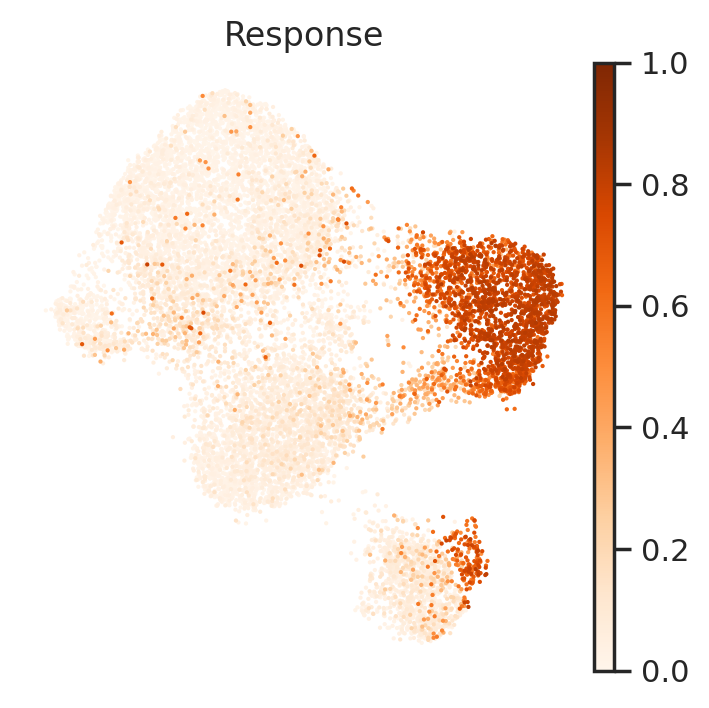

In [20]:
pert.obs['Response']=np.asarray(y)
sc.pl.umap(pert, color='Response', frameon=False, cmap='Oranges', vmin=0, vmax=1)

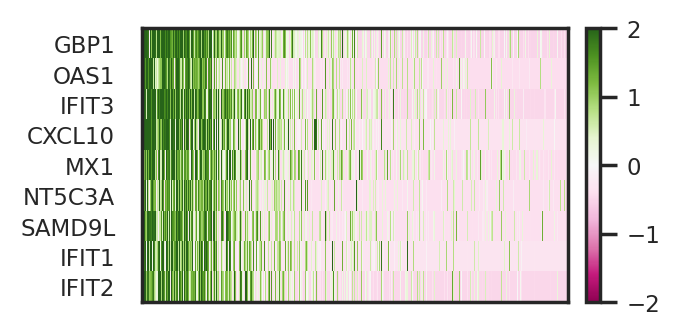

In [21]:
expr = X.loc[:,selected_genes]
expr['Response']=y
expr = expr.sort_values(by=['Response'],ascending=False)

x = np.asarray(expr.values[:,:-1]).squeeze()
x = gaussian_filter1d(x, 1, axis=0, mode='nearest')
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True, figsize=(3,x.shape[1]*0.2))
sns.set_theme(style='white', font_scale=0.75)
im = plt.imshow(x.T, cmap="PiYG", vmin=-2, vmax=2,aspect='auto',interpolation='nearest')
plt.grid(False)
plt.xticks(
    []
)
plt.yticks(
    ticks=range(len(expr.columns)-1),
    labels=expr.columns.tolist()[:-1],
)
plt.colorbar(im, fraction=0.05, pad=0.04)

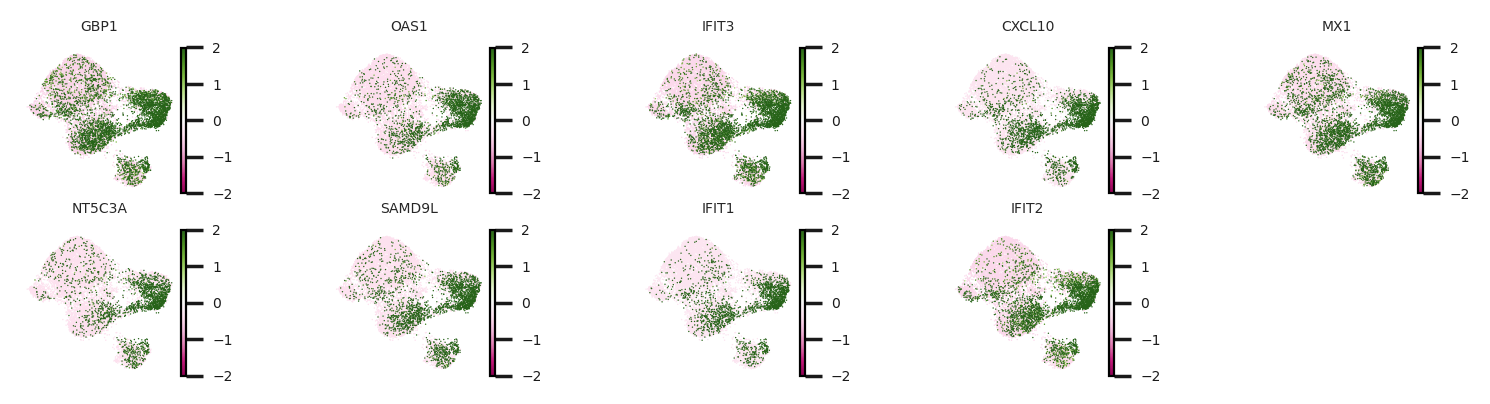

In [23]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True, figsize=(1,1),fontsize=5)
sc.pl.umap(pert, color=selected_genes, ncols=5, frameon=False, cmap='PiYG',layer='scaled', vmin=-2, vmax=2,size=1)

CellCap identified a subpopulation of monocytes has higher response to CA at 3h time point. Meanwhile, we identified perturbed genes of Q6, including IFIT1, IFIT2, and IFIT3. Experssion patterns of these perturbed genes also greatly agree with the response pattern.

## Uncover the corresponded basal state <a class="anchor" id="basal-state"></a>
following up program Q6, we next aim to cellular identity that explains the response amplitude of Q6. Different from identifying perturbed genes of Q6, we will use basal state of to retrieve a basal program relevant to perturbation program Q6. To do so, we calculate cosine similarity of perturbation key of CA at 3h time point to basal states of all control cells. We then sort cells from high cosine similarity to low. Next, we combine linear regression and `SelectKBest` in sklearn to identify top basal genes that explain cellular identity of this subpopulation of monocytes.

In [24]:
#get perturatbion key
H_key = cellcap.get_H_key()

In [25]:
X = adata[adata.obs['timepoint']=='UT'].layers['scaled']
X = pd.DataFrame(X)
X.columns = adata.var.index

head_index = 1
y = cosine_distance(control.obsm['X_basal'],H_key[drug_names.index('3hCA'),(prog_index-1),:,head_index])

In [26]:
reg = linear_model.BayesianRidge(fit_intercept=False)
reg.fit(X, y)

gene_weights = pd.DataFrame(reg.coef_)
gene_weights.index = X.columns
Bgene=gene_weights[gene_weights[0]>0][0].sort_values(ascending = False).index.tolist()

k = 10 # 50
topk = SelectKBest(f_regression, k=k).fit(X.loc[:,Bgene], y)
top_feature_indices = topk.get_support(indices=True)
selected_basal = topk.get_feature_names_out().tolist()

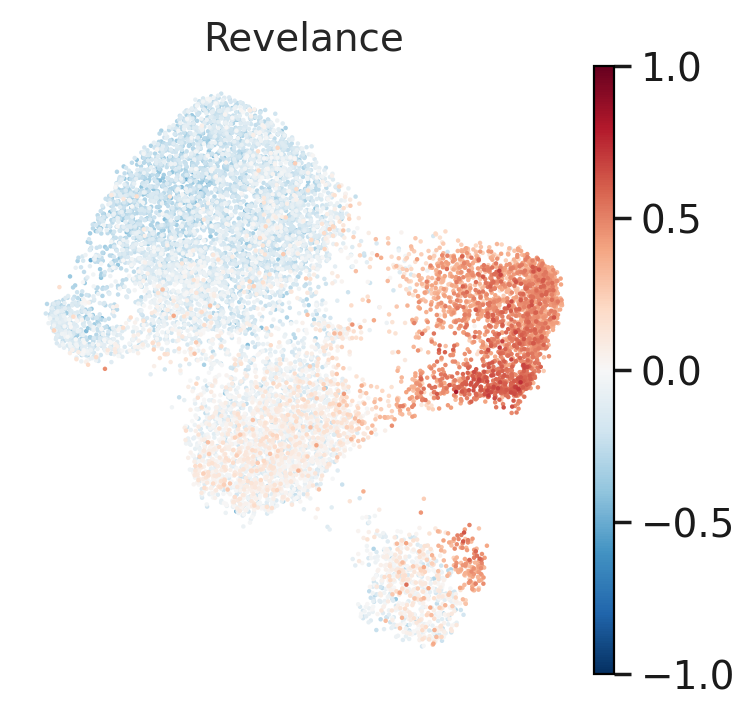

In [27]:
control.obs['Revelance']=np.array(y)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100,vector_friendly=True)
sc.pl.umap(control, color='Revelance', frameon=False, cmap='RdBu_r', vmin=-1, vmax=1)

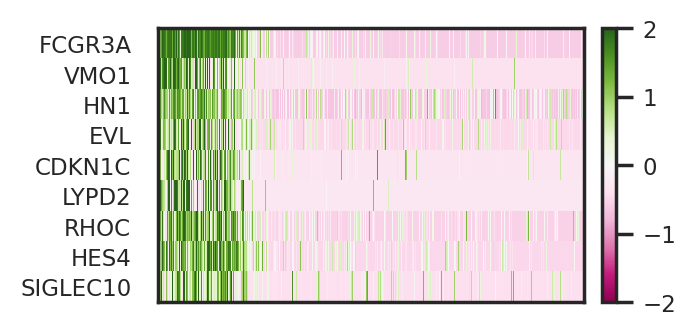

In [28]:
expr = X.loc[:,selected_basal]
expr = expr.iloc[:,:-1]
expr['Relevance']=y
expr = expr.sort_values(by=['Relevance'],ascending=False)

x = np.asarray(expr.values[:,:-1]).squeeze()
x = gaussian_filter1d(x, 1, axis=0, mode='nearest')
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True, figsize=(3,x.shape[1]*0.2))
sns.set_theme(style='white', font_scale=0.75)
im = plt.imshow(x.T, cmap="PiYG", vmin=-2, vmax=2,aspect='auto',interpolation='nearest')
plt.grid(False)
plt.xticks(
    []
)
plt.yticks(
    ticks=range(len(expr.columns)-1),
    labels=expr.columns.tolist()[:-1],
)
plt.colorbar(im, fraction=0.05, pad=0.04)

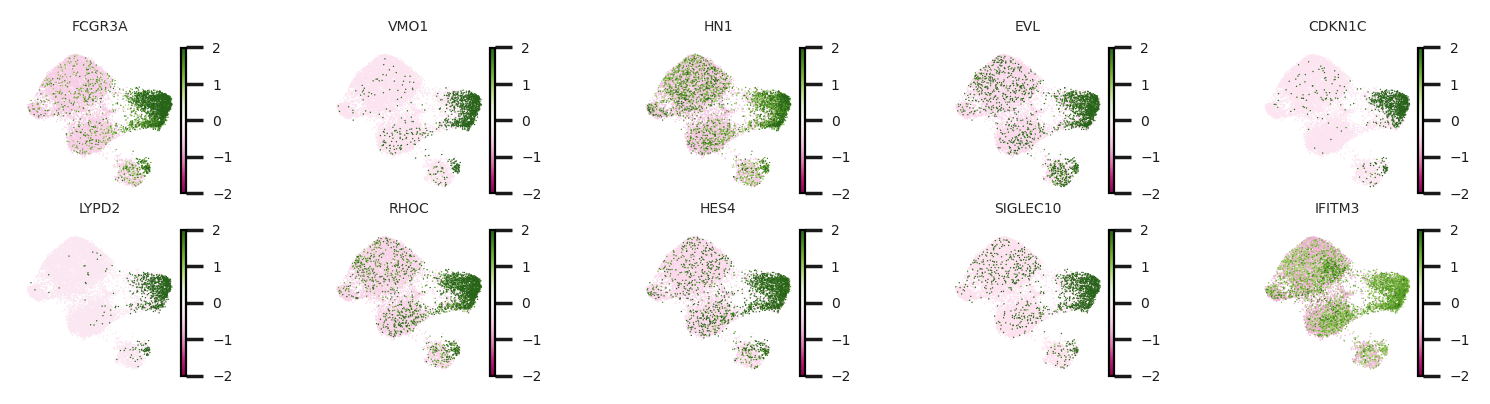

In [29]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True, figsize=(1,1),fontsize=5)
sc.pl.umap(control, color=selected_basal,ncols=5, frameon=False, cmap='PiYG',layer='scaled', 
           vmin=-2, vmax=2, size=1)

To briefly summarize results above, we identified two gene sets, perturbed genes of Q6 and basal genes relevant to Q6. Here, we want to emphasize the correspondence between basal genes relevant to Q6 and the perturbed genes of Q6. Basal genes should be interpreted as markers for cellular identity of this subpopulation of monocytes, while perturbed genes serve to reveal a perturbation response of this subpopulation to pathogen CA.